In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os 

from scipy.stats import ttest_rel

params = {'legend.fontsize': 18,
          'figure.figsize': (13, 10),
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'axes.linewidth':5,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(123)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-75ap08uz because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def format_data(df, species, metabolites, controls, obj_params=None, t_eval=None):
    '''
    Format data so that all experiments have same time length and time steps with
    NaNs filled in missing entries

    df is a dataframe with columns
    ['Experiments', 'Time', 'S_1', ..., 'S_ns', 'M_1', ..., 'M_nm', 'U_1', ..., 'U_nu']

    species := 'S_1', ..., 'S_ns'
    metabolites := 'M_1', ..., 'M_nm'
    controls := 'U_1', ..., 'U_nu'

    '''
    # concatenate all sytem variable names
    sys_vars = np.concatenate((species, metabolites, controls))

    # get experiment names
    experiments = df.Experiments.values

    # get unique experiments and number of time measurements
    unique_exps, counts = np.unique(experiments, return_counts=True)

    # determine time vector corresponding to longest sampled experiment
    if t_eval is None:
        exp_longest = unique_exps[np.argmax(counts)]
        exp_longest_inds = np.in1d(experiments, exp_longest)
        t_eval = df.iloc[exp_longest_inds]['Time'].values

    # initialize data matrix with NaNs
    D = np.empty([len(unique_exps), len(t_eval), len(sys_vars)])
    D[:] = np.nan

    # initialize matrix of objective parameters if provided
    if obj_params is not None:
        P = np.zeros([len(unique_exps), len(t_eval), len(obj_params)])

    # fill in data for each experiment
    exp_names = []
    N = 0
    effective_dimension = 0
    dimension = 0
    for i,exp in enumerate(unique_exps):
        exp_inds  = np.in1d(experiments, exp)
        comm_data = df.copy()[exp_inds]

        # count number of samples
        N += len(t_eval[1:])
        # pull species data
        Y_species = np.array(comm_data[species].values, float)
        # count effective dimension
        effective_dimension += np.sum(Y_species[0] > 0.)
        dimension += Y_species.shape[1]

        # store data
        exp_time = comm_data['Time'].values
        sampling_inds = np.in1d(t_eval, exp_time)
        D[i][sampling_inds] = comm_data[sys_vars].values
        exp_names += [exp]*len(t_eval)

        # store objective params
        if obj_params is not None:
            P[i][sampling_inds] = comm_data[obj_params].values

    # compute N, accounting for missing species
    N *= effective_dimension / dimension

    if obj_params is not None:
        return np.array(D), np.array(P), unique_exps, N
    else:
        return np.array(D), unique_exps, N
    
def mean_pm_stdv(df):
    mean = df.loc[df.index=='mean'].values[0][1:]
    mean_m_stdv = mean - df.loc[df.index=='std'].values[0][1:]
    mean_p_stdv = mean + df.loc[df.index=='std'].values[0][1:]
    return np.stack((mean_m_stdv, mean, mean_p_stdv))

# Define parameters used for DTL simulation

In [3]:
# number of dtl cycles 
n_dtl = 5

# define number of initial samples to train on
n_init = 5

# number of samples for next experiment 
n_test = 5

# number of species in model
n_s = 5

# number of resources
n_r = 7

# define all system variables 
species = ['s'+str(i+1) for i in range(n_s)]
outputs = ['volume', 'product']
sys_var = species + outputs

# define subset of controls
controls = ['rf'+str(i+1) for i in range(n_r)] + ['feed']
system_variables = species + outputs + controls

# define an objective function
objective = lambda pred: pred[-1, -2]*pred[-1, -1] # product of endpoint volume * product conc. 

# import data 
main_df = pd.read_csv("../Data/reactor_ubiome.csv")
all_exp_names = main_df.Experiments.values

# determine sampling times
sample_times = np.unique(main_df.Time.values)

# format data 
main_data, unique_exp_names, N_total = format_data(main_df, species, outputs, controls)

# keep track of objective 
objective_found = []

# determine target values over entire design space 
target_true = []
for sample in main_data:
    target_true.append(objective(sample[:, :len(sys_var)]))
target_true = np.array(target_true)

# Import DTL results

In [4]:
dtl_df = pd.read_csv("miRNN_explore_exploit_FAST.csv").describe()
dtl_df_exploit = pd.read_csv("miRNN_exploit.csv").describe()
dtl_df_explore = pd.read_csv("miRNN_explore.csv").describe()
dtl_df_rand = pd.read_csv("miRNN_random.csv").describe()

# compare percentiles
dtl_data = np.zeros([3, n_dtl+1])
dtl_data_exploit = np.zeros([3, n_dtl+1])
dtl_data_explore = np.zeros([3, n_dtl+1])
dtl_data_rand = np.zeros([3, n_dtl+1])
dtl_data_FIM  = np.zeros([3, n_dtl+1])

percentiles = ['25%', '50%', '75%']
for i,percentile in enumerate(percentiles):
    dtl_data[i] = dtl_df.loc[dtl_df.index==percentile].values[0][1:]
    dtl_data_exploit[i] = dtl_df_exploit.loc[dtl_df_exploit.index==percentile].values[0][1:]
    dtl_data_explore[i] = dtl_df_explore.loc[dtl_df_explore.index==percentile].values[0][1:]
    dtl_data_rand[i] = dtl_df_rand.loc[dtl_df_rand.index==percentile].values[0][1:]
    
# compare mean +/- stdv
# dtl_data = mean_pm_stdv(dtl_df)
# dtl_data_exploit = mean_pm_stdv(dtl_df_exploit) 
# dtl_data_explore = mean_pm_stdv(dtl_df_explore) 
# dtl_data_rand = mean_pm_stdv(dtl_df_rand) 

# Plot optimization results

## Random trials

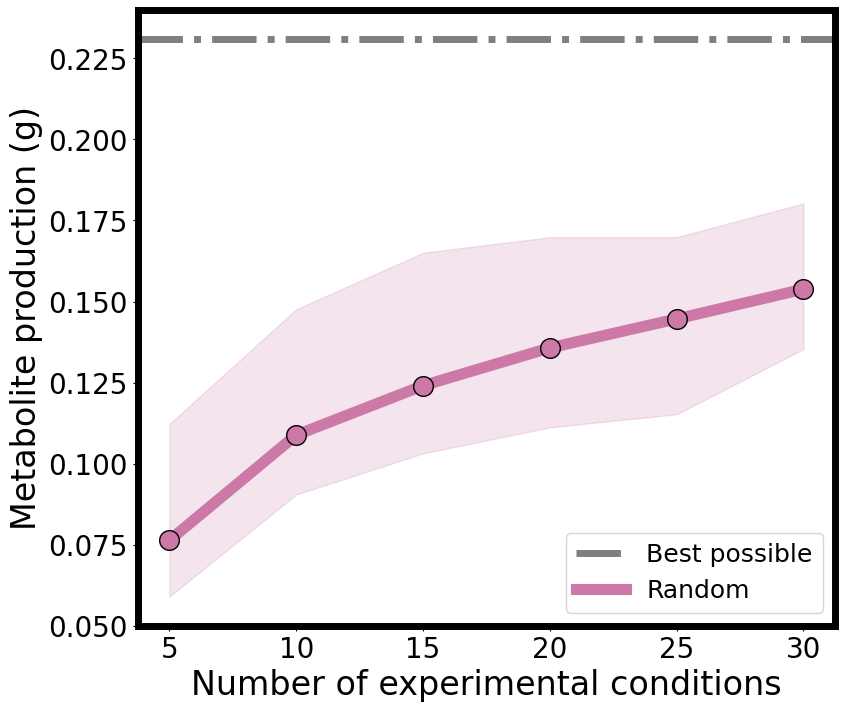

In [5]:
# plot best possible scenario 
fig, ax = plt.subplots(figsize=(9, 8))
plt.axhline(np.max(target_true), linewidth=5, linestyle='-.', c='k', alpha=.5, label="Best possible")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_rand[1], linewidth=8, zorder=3, label='Random',color="C3")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_rand[1], s=200, edgecolor='k', zorder=4, color="C3")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_rand[2], dtl_data_rand[0], alpha=.2, color="C3")

# labels
plt.ylabel("Metabolite production (g)")
plt.xlabel("Number of experimental conditions")
plt.xticks([5, 10, 15, 20, 25, 30])
plt.legend(loc='lower right')
plt.ylim([0.05, .24])
plt.savefig("random_design.pdf", dpi=300)
plt.show()

## Compare BO to exploitation and pure exploration

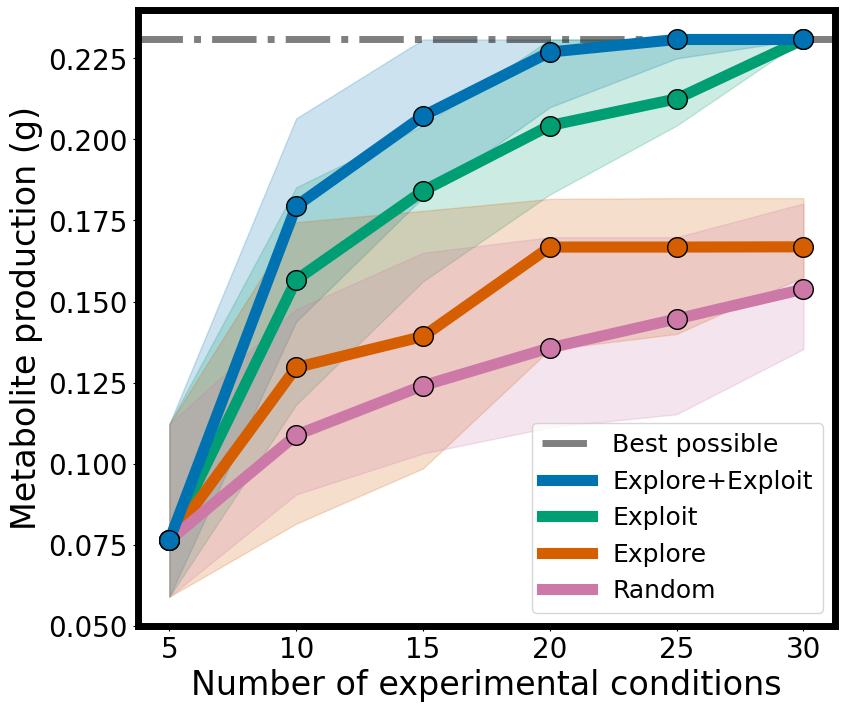

In [6]:
# plot best possible scenario 
fig, ax = plt.subplots(figsize=(9, 8))
plt.axhline(np.max(target_true), linewidth=5, linestyle='-.', c='k', alpha=.5, label="Best possible")

# plot best target found 
plt.plot([5, 10, 15, 20, 25, 30], dtl_data[1], linewidth=8, zorder=4, label='Explore+Exploit',color="C0")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data[1], s=200, edgecolor='k', zorder=5, color="C0")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data[2], dtl_data[0], alpha=.2, color="C0")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_exploit[1], linewidth=8, zorder=3, label='Exploit',color="C1")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_exploit[1], s=200, edgecolor='k', zorder=4, color="C1")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_exploit[2], dtl_data_exploit[0], alpha=.2, color="C1")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_explore[1], linewidth=8, zorder=3, label='Explore',color="C2")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_explore[1], s=200, edgecolor='k', zorder=4, color="C2")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_explore[2], dtl_data_explore[0], alpha=.2, color="C2")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_rand[1], linewidth=8, zorder=3, label='Random',color="C3")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_rand[1], s=200, edgecolor='k', zorder=4, color="C3")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_rand[2], dtl_data_rand[0], alpha=.2, color="C3")

# labels
plt.ylabel("Metabolite production (g)")
plt.xlabel("Number of experimental conditions")
plt.xticks([5, 10, 15, 20, 25, 30])
plt.legend(loc='lower right')
plt.ylim([0.05, .24])
plt.savefig("design_comparison.pdf", dpi=300)
plt.show()

## Compare MiRNN BO to GP BO

In [7]:
dtl_df_gp = pd.read_csv("GP.csv").describe()
# dtl_df_gp = pd.read_csv("GP_batch.csv").describe()

# compare percentiles
dtl_data_gp = np.zeros([3, 5*5 + 1]) # 25 dtl cycles w/ 1 condition + initial experiment w/ 5 conditions

percentiles = ['25%', '50%', '75%']
for i,percentile in enumerate(percentiles):
    dtl_data_gp[i] = dtl_df_gp.loc[dtl_df_rand.index==percentile].values[0][1:]

# compare mean pm stdv
#dtl_data_gp = mean_pm_stdv(dtl_df_gp)

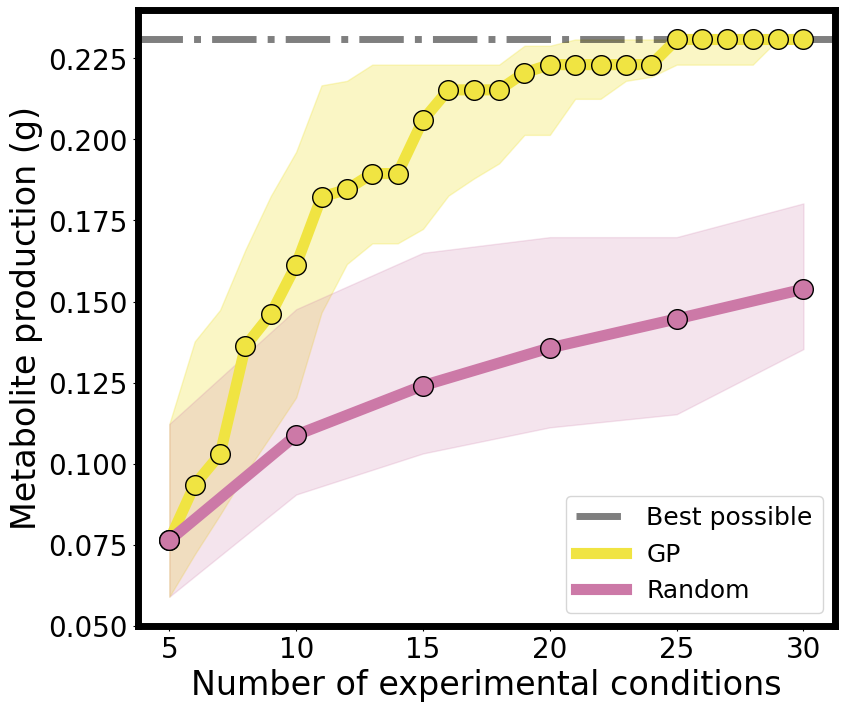

In [8]:
# plot best possible scenario 
fig, ax = plt.subplots(figsize=(9, 8))
plt.axhline(np.max(target_true), linewidth=5, linestyle='-.', c='k', alpha=.5, label="Best possible")

plt.plot(np.arange(5, 31), dtl_data_gp[1], linewidth=8, zorder=3, label='GP',color="C4")
plt.scatter(np.arange(5, 31), dtl_data_gp[1], s=200, edgecolor='k', zorder=4, color="C4")
plt.fill_between(np.arange(5, 31), dtl_data_gp[2], dtl_data_gp[0], alpha=.3, color="C4")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_rand[1], linewidth=8, zorder=3, label='Random',color="C3")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_rand[1], s=200, edgecolor='k', zorder=4, color="C3")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_rand[2], dtl_data_rand[0], alpha=.2, color="C3")

# labels
plt.ylabel("Metabolite production (g)")
plt.xlabel("Number of experimental conditions")
plt.xticks([5, 10, 15, 20, 25, 30])
plt.legend(loc='lower right')
plt.ylim([0.05, .24])
plt.savefig("GP_comparison_rand.pdf", dpi=300)
plt.show()

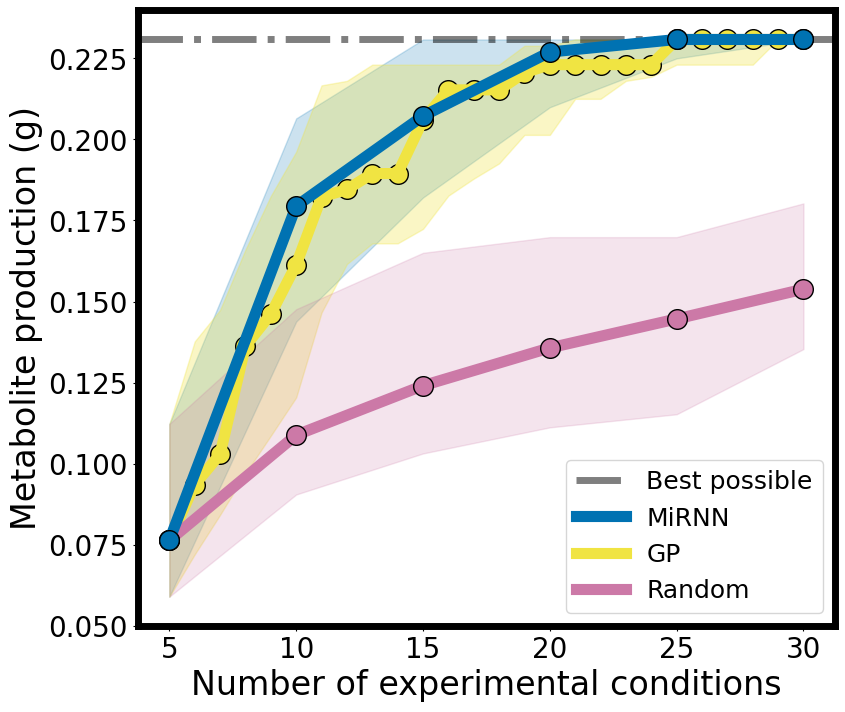

In [9]:
# plot best possible scenario 
fig, ax = plt.subplots(figsize=(9, 8))
plt.axhline(np.max(target_true), linewidth=5, linestyle='-.', c='k', alpha=.5, label="Best possible")

# plot best target found 
plt.plot([5, 10, 15, 20, 25, 30], dtl_data[1], linewidth=8, zorder=4, label='MiRNN',color="C0")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data[1], s=200, edgecolor='k', zorder=5, color="C0")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data[2], dtl_data[0], alpha=.2, color="C0")

plt.plot(np.arange(5, 31), dtl_data_gp[1], linewidth=8, zorder=3, label='GP',color="C4")
plt.scatter(np.arange(5, 31), dtl_data_gp[1], s=200, edgecolor='k', zorder=3, color="C4")
plt.fill_between(np.arange(5, 31), dtl_data_gp[2], dtl_data_gp[0], alpha=.3, color="C4")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_rand[1], linewidth=8, zorder=3, label='Random',color="C3")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_rand[1], s=200, edgecolor='k', zorder=4, color="C3")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_rand[2], dtl_data_rand[0], alpha=.2, color="C3")

# labels
plt.ylabel("Metabolite production (g)")
plt.xlabel("Number of experimental conditions")
plt.xticks([5, 10, 15, 20, 25, 30])
plt.legend(loc='lower right')
plt.ylim([0.05, .24])
plt.savefig("GP_comparison.pdf", dpi=300)
plt.show()

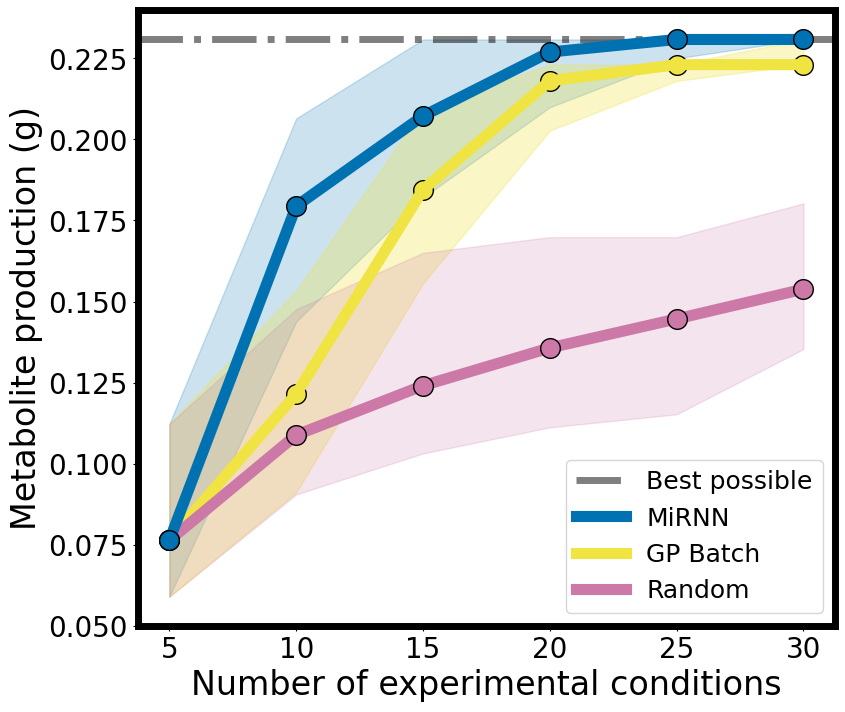

In [10]:
dtl_df_gp = pd.read_csv("GP_batch.csv").describe()

# compare percentiles
dtl_data_gp = np.zeros([3, n_dtl + 1]) # 25 dtl cycles w/ 1 condition + initial experiment w/ 5 conditions

percentiles = ['25%', '50%', '75%']
for i,percentile in enumerate(percentiles):
    dtl_data_gp[i] = dtl_df_gp.loc[dtl_df_rand.index==percentile].values[0][1:]

# plot best possible scenario 
fig, ax = plt.subplots(figsize=(9, 8))
plt.axhline(np.max(target_true), linewidth=5, linestyle='-.', c='k', alpha=.5, label="Best possible")

# plot best target found 
plt.plot([5, 10, 15, 20, 25, 30], dtl_data[1], linewidth=8, zorder=4, label='MiRNN',color="C0")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data[1], s=200, edgecolor='k', zorder=5, color="C0")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data[2], dtl_data[0], alpha=.2, color="C0")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_gp[1], linewidth=8, zorder=3, label='GP Batch',color="C4")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_gp[1], s=200, edgecolor='k', zorder=3, color="C4")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_gp[2], dtl_data_gp[0], alpha=.3, color="C4")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_rand[1], linewidth=8, zorder=3, label='Random',color="C3")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_rand[1], s=200, edgecolor='k', zorder=4, color="C3")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_rand[2], dtl_data_rand[0], alpha=.2, color="C3")

# labels
plt.ylabel("Metabolite production (g)")
plt.xlabel("Number of experimental conditions")
plt.xticks([5, 10, 15, 20, 25, 30])
plt.legend(loc='lower right')
plt.ylim([0.05, .24])
plt.savefig("GP_batch_comparison.pdf", dpi=300)
plt.show()

In [11]:
# evaluate statistical significance over DTL cycles btw Explore+Exploit vs. Exploit 
dtl_df = pd.read_csv("miRNN_explore_exploit_FAST.csv")
dtl_df_exploit = pd.read_csv("miRNN_exploit.csv")

# dtl 1
pval = ttest_rel(dtl_df['DTL 1'].values, dtl_df_exploit['DTL 1'].values).pvalue
print("DTL 1 p-value: {:.5f}".format(pval))

# dtl 2
pval = ttest_rel(dtl_df['DTL 2'].values, dtl_df_exploit['DTL 2'].values).pvalue
print("DTL 2 p-value: {:.5f}".format(pval))

# dtl 1
pval = ttest_rel(dtl_df['DTL 3'].values, dtl_df_exploit['DTL 3'].values).pvalue
print("DTL 3 p-value: {:.5f}".format(pval))

# dtl 1
pval = ttest_rel(dtl_df['DTL 4'].values, dtl_df_exploit['DTL 4'].values).pvalue
print("DTL 4 p-value: {:.5f}".format(pval))

# dtl 1
pval = ttest_rel(dtl_df['DTL 5'].values, dtl_df_exploit['DTL 5'].values).pvalue
print("DTL 5 p-value: {:.5f}".format(pval))

DTL 1 p-value: 0.00170
DTL 2 p-value: 0.01277
DTL 3 p-value: 0.00240
DTL 4 p-value: 0.00307
DTL 5 p-value: 0.02032


# Compare prediction performance

In [12]:
dtl_df = pd.read_csv("miRNN_explore_exploit_FAST_rvals.csv").describe()
dtl_df_exploit = pd.read_csv("miRNN_exploit_rvals.csv").describe()
dtl_df_explore = pd.read_csv("miRNN_explore_rvals.csv").describe()
dtl_df_rand = pd.read_csv("miRNN_random_rvals.csv").describe()

# compare percentiles
percentiles = ['25%', '50%', '75%']
dtl_data = np.zeros([3, n_dtl+1])
dtl_data_exploit = np.zeros([3, n_dtl+1])
dtl_data_explore = np.zeros([3, n_dtl+1])
dtl_data_rand = np.zeros([3, n_dtl+1])

for i,percentile in enumerate(percentiles):
    dtl_data[i] = dtl_df.loc[dtl_df.index==percentile].values[0][1:]
    dtl_data_exploit[i] = dtl_df_exploit.loc[dtl_df_exploit.index==percentile].values[0][1:]
    dtl_data_explore[i] = dtl_df_explore.loc[dtl_df_explore.index==percentile].values[0][1:]
    dtl_data_rand[i] = dtl_df_rand.loc[dtl_df_rand.index==percentile].values[0][1:]

# # compare mean +/- stdv
# dtl_data = mean_pm_stdv(dtl_df)
# dtl_data_exploit = mean_pm_stdv(dtl_df_exploit) 
# dtl_data_explore = mean_pm_stdv(dtl_df_explore) 
# dtl_data_rand = mean_pm_stdv(dtl_df_rand) 

In [13]:
dtl_df

,Trial,DTL 0,DTL 1,DTL 2,DTL 3,DTL 4,DTL 5
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,0.552301,0.578134,0.698747,0.782523,0.858217,0.850295
std,8.803408,0.178057,0.222181,0.159437,0.132436,0.043458,0.095493
min,0.000000,0.140503,0.045257,0.182644,0.386469,0.784377,0.618094
25%,7.250000,0.431933,0.474367,0.630946,0.734850,0.823044,0.818594
50%,14.500000,0.561969,0.645295,0.735324,0.813063,0.857737,0.879833
75%,21.750000,0.706380,0.752173,0.788951,0.887160,0.896596,0.914709
max,29.000000,0.832350,0.887952,0.941492,0.930940,0.928274,0.949774


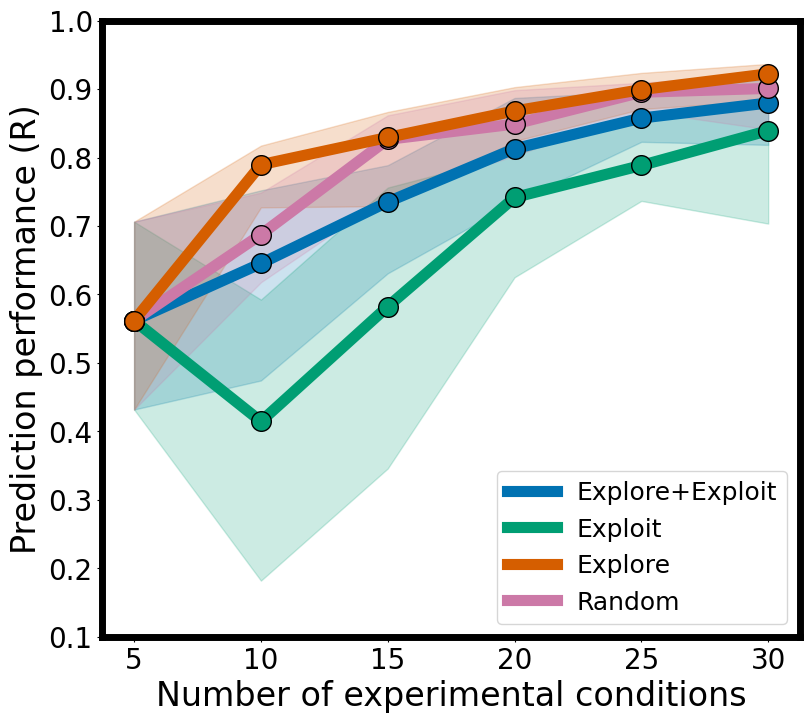

In [14]:
# plot best possible scenario 
fig, ax = plt.subplots(figsize=(9, 8))

# plot best target found 
plt.plot([5, 10, 15, 20, 25, 30], dtl_data[1], linewidth=8, zorder=3, label='Explore+Exploit',color="C0")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data[1], s=200, edgecolor='k', zorder=4, color="C0")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data[2], dtl_data[0], alpha=.2, color="C0")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_exploit[1], linewidth=8, zorder=3, label='Exploit',color="C1")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_exploit[1], s=200, edgecolor='k', zorder=4, color="C1")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_exploit[2], dtl_data_exploit[0], alpha=.2, color="C1")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_explore[1], linewidth=8, zorder=4, label='Explore',color="C2")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_explore[1], s=200, edgecolor='k', zorder=5, color="C2")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_explore[2], dtl_data_explore[0], alpha=.2, color="C2")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_rand[1], linewidth=8, zorder=3, label='Random',color="C3")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_rand[1], s=200, edgecolor='k', zorder=4, color="C3")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_rand[2], dtl_data_rand[0], alpha=.2, color="C3")

# labels
plt.legend(loc='lower right')
plt.ylim([.1, 1])
plt.ylabel("Prediction performance (R)")
plt.xlabel("Number of experimental conditions")
plt.savefig("design_comparison_rvals.pdf", dpi=300)
plt.show()

In [15]:
# evaluate statistical significance over DTL cycles btw Explore+Exploit vs. Exploit 
dtl_df = pd.read_csv("miRNN_explore_rvals.csv")
dtl_df_exploit = pd.read_csv("miRNN_random_rvals.csv")

# dtl 1
pval = ttest_rel(dtl_df['DTL 1'].values, dtl_df_exploit['DTL 1'].values).pvalue
print("DTL 1 p-value: {:.5f}".format(pval))

# dtl 2
pval = ttest_rel(dtl_df['DTL 2'].values, dtl_df_exploit['DTL 2'].values).pvalue
print("DTL 2 p-value: {:.5f}".format(pval))

# dtl 1
pval = ttest_rel(dtl_df['DTL 3'].values, dtl_df_exploit['DTL 3'].values).pvalue
print("DTL 3 p-value: {:.5f}".format(pval))

# dtl 1
pval = ttest_rel(dtl_df['DTL 4'].values, dtl_df_exploit['DTL 4'].values).pvalue
print("DTL 4 p-value: {:.5f}".format(pval))

# dtl 1
pval = ttest_rel(dtl_df['DTL 5'].values, dtl_df_exploit['DTL 5'].values).pvalue
print("DTL 5 p-value: {:.5f}".format(pval))

DTL 1 p-value: 0.00334
DTL 2 p-value: 0.95763
DTL 3 p-value: 0.12983
DTL 4 p-value: 0.91729
DTL 5 p-value: 0.07117


# Compare prediction performance (RMSE)

In [30]:
# import data 
dtl_df = pd.read_csv("miRNN_explore_exploit_FAST_sse.csv") 
dtl_df_exploit = pd.read_csv("miRNN_exploit_sse.csv")
dtl_df_explore = pd.read_csv("miRNN_explore_sse.csv")
dtl_df_rand = pd.read_csv("miRNN_random_sse.csv")

# convert SSE to RMSE 
for dtl in np.arange(6):
    # divide SSE by number of remaining samples in design space, take square root
    dtl_df[f'DTL {dtl}'] = np.sqrt(dtl_df[f'DTL {dtl}'].values / (2540 - (dtl+1)*5))
    
# convert SSE to RMSE 
for dtl in np.arange(6):
    # divide SSE by number of remaining samples in design space, take square root
    dtl_df_exploit[f'DTL {dtl}'] = np.sqrt(dtl_df_exploit[f'DTL {dtl}'].values / (2540 - (dtl+1)*5))
    
# convert SSE to RMSE 
for dtl in np.arange(6):
    # divide SSE by number of remaining samples in design space, take square root
    dtl_df_explore[f'DTL {dtl}'] = np.sqrt(dtl_df_explore[f'DTL {dtl}'].values / (2540 - (dtl+1)*5))
    
# convert SSE to RMSE 
for dtl in np.arange(6):
    # divide SSE by number of remaining samples in design space, take square root
    dtl_df_rand[f'DTL {dtl}'] = np.sqrt(dtl_df_rand[f'DTL {dtl}'].values / (2540 - (dtl+1)*5))

# compute statistics
dtl_df = dtl_df.describe()
dtl_df_exploit = dtl_df_exploit.describe()
dtl_df_explore = dtl_df_explore.describe()
dtl_df_rand = dtl_df_rand.describe()
    
# compare percentiles
percentiles = ['25%', '50%', '75%']
dtl_data = np.zeros([3, n_dtl+1])
dtl_data_exploit = np.zeros([3, n_dtl+1])
dtl_data_explore = np.zeros([3, n_dtl+1])
dtl_data_rand = np.zeros([3, n_dtl+1])

for i,percentile in enumerate(percentiles):
    dtl_data[i] = dtl_df.loc[dtl_df.index==percentile].values[0][1:]
    dtl_data_exploit[i] = dtl_df_exploit.loc[dtl_df_exploit.index==percentile].values[0][1:]
    dtl_data_explore[i] = dtl_df_explore.loc[dtl_df_explore.index==percentile].values[0][1:]
    dtl_data_rand[i] = dtl_df_rand.loc[dtl_df_rand.index==percentile].values[0][1:]

# # compare mean +/- stdv
# dtl_data = mean_pm_stdv(dtl_df)
# dtl_data_exploit = mean_pm_stdv(dtl_df_exploit) 
# dtl_data_explore = mean_pm_stdv(dtl_df_explore) 
# dtl_data_rand = mean_pm_stdv(dtl_df_rand) 

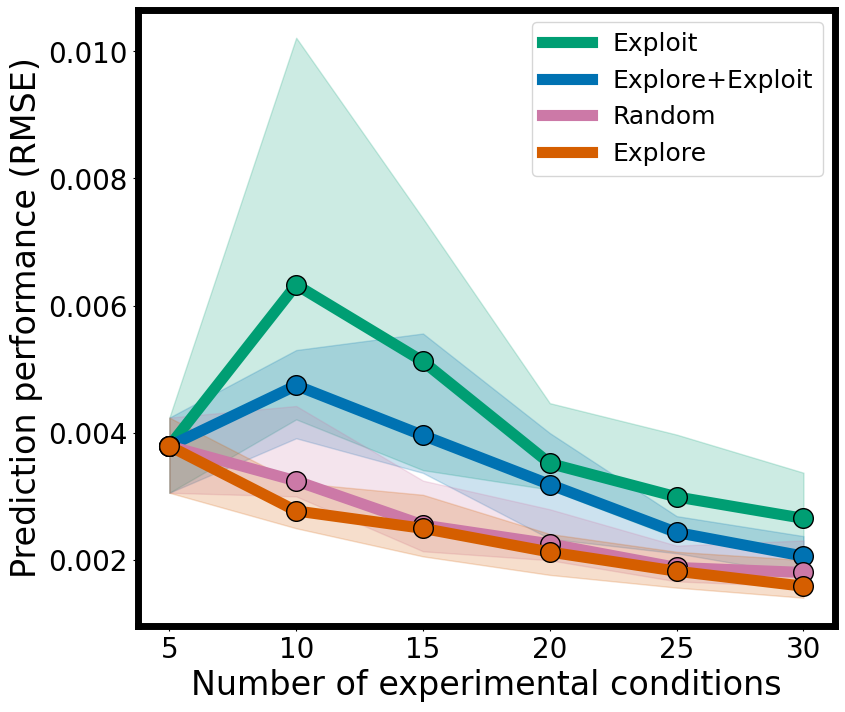

In [32]:
# plot best possible scenario 
fig, ax = plt.subplots(figsize=(9, 8))

# plot best target found 
plt.plot([5, 10, 15, 20, 25, 30], dtl_data_exploit[1], linewidth=8, zorder=3, label='Exploit',color="C1")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_exploit[1], s=200, edgecolor='k', zorder=4, color="C1")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_exploit[2], dtl_data_exploit[0], alpha=.2, color="C1")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data[1], linewidth=8, zorder=3, label='Explore+Exploit',color="C0")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data[1], s=200, edgecolor='k', zorder=4, color="C0")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data[2], dtl_data[0], alpha=.2, color="C0")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_rand[1], linewidth=8, zorder=3, label='Random',color="C3")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_rand[1], s=200, edgecolor='k', zorder=4, color="C3")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_rand[2], dtl_data_rand[0], alpha=.2, color="C3")

plt.plot([5, 10, 15, 20, 25, 30], dtl_data_explore[1], linewidth=8, zorder=4, label='Explore',color="C2")
plt.scatter([5, 10, 15, 20, 25, 30], dtl_data_explore[1], s=200, edgecolor='k', zorder=5, color="C2")
plt.fill_between([5, 10, 15, 20, 25, 30], dtl_data_explore[2], dtl_data_explore[0], alpha=.2, color="C2")

# labels
plt.legend(loc='upper right')
# plt.ylim([.1, 1])
plt.ylabel("Prediction performance (RMSE)")
plt.xlabel("Number of experimental conditions")
plt.savefig("design_comparison_rmse.pdf", dpi=300)
plt.show()

In [33]:
# evaluate statistical significance over DTL cycles btw Explore+Exploit vs. Exploit 
dtl_df = pd.read_csv("miRNN_explore_sse.csv")
dtl_df_exploit = pd.read_csv("miRNN_random_sse.csv")

# dtl 1
pval = ttest_rel(dtl_df['DTL 1'].values, dtl_df_exploit['DTL 1'].values).pvalue
print("DTL 1 p-value: {:.5f}".format(pval))

# dtl 2
pval = ttest_rel(dtl_df['DTL 2'].values, dtl_df_exploit['DTL 2'].values).pvalue
print("DTL 2 p-value: {:.5f}".format(pval))

# dtl 1
pval = ttest_rel(dtl_df['DTL 3'].values, dtl_df_exploit['DTL 3'].values).pvalue
print("DTL 3 p-value: {:.5f}".format(pval))

# dtl 1
pval = ttest_rel(dtl_df['DTL 4'].values, dtl_df_exploit['DTL 4'].values).pvalue
print("DTL 4 p-value: {:.5f}".format(pval))

# dtl 1
pval = ttest_rel(dtl_df['DTL 5'].values, dtl_df_exploit['DTL 5'].values).pvalue
print("DTL 5 p-value: {:.5f}".format(pval))

DTL 1 p-value: 0.04076
DTL 2 p-value: 0.31398
DTL 3 p-value: 0.06101
DTL 4 p-value: 0.50623
DTL 5 p-value: 0.42198
